# Estimate model of WTI oil futures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()



Download dataset with latest data
(Data is for every business day)

In [2]:
raw_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RCLC1d.xls", sheet_name=1, header=2)

In [3]:
raw_data.head()

,Date,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
0,1983-04-04,29.44
1,1983-04-05,29.71
2,1983-04-06,29.92
3,1983-04-07,30.17
4,1983-04-08,30.38


In [4]:
# check date of the oldest and the newest entry
print("Oldest entry: ", raw_data["Date"].min())
print("Newest entry: ", raw_data["Date"].max())

Oldest entry:  1983-04-04 00:00:00
Newest entry:  2020-03-19 00:00:00


In [5]:
# set date as index for easier time series handling
time_indexed_data = raw_data.set_index("Date")
time_indexed_data.head()

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)"
Date,
1983-04-04,29.44
1983-04-05,29.71
1983-04-06,29.92
1983-04-07,30.17
1983-04-08,30.38


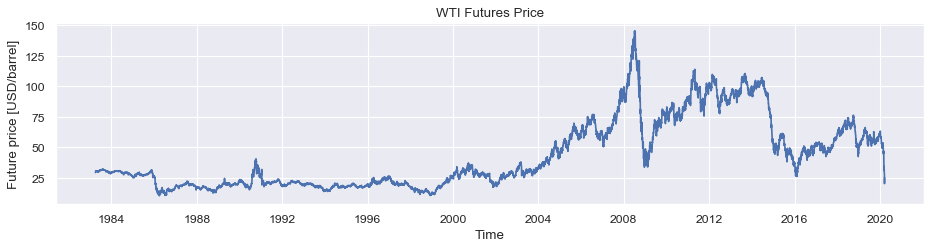

In [6]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time_indexed_data)
plt.title("WTI Futures Price")
plt.xlabel("Time")
plt.ylabel("Future price [USD/barrel]")
plt.show()

Select time interval

In [25]:
selected_ti = time_indexed_data.loc["2015-01-01":]
selected_ti.count()

Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)    1318
dtype: int64

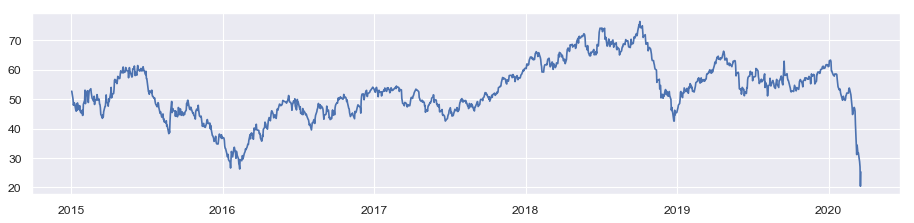

In [26]:
plt.figure(figsize=(14, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(selected_ti)
plt.show()

In [18]:
rets = selected_ti/selected_ti.shift(1)
print(selected_ti.head())
print(selected_ti.shift(1).head())
print(rets.head())
rets = rets[rets.columns[0]].dropna()
#rets = selected_ti.pct_change()
#rets = rets.rename(columns={rets.columns[0] : "% return"})
#rets["% return"] = rets["% return"].dropna()

            Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)
Date                                                                    
2015-01-02                                              52.69           
2015-01-05                                              50.04           
2015-01-06                                              47.93           
2015-01-07                                              48.65           
2015-01-08                                              48.79           
            Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)
Date                                                                    
2015-01-02                                                NaN           
2015-01-05                                              52.69           
2015-01-06                                              50.04           
2015-01-07                                              47.93           
2015-01-08                                         

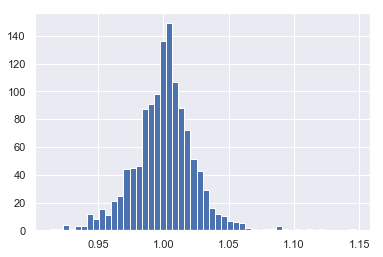

In [10]:
plt.hist(rets,bins=50)
plt.show()

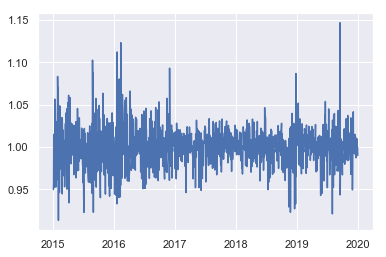

In [11]:
plt.plot(rets)

In [12]:
lrets = np.log(rets)

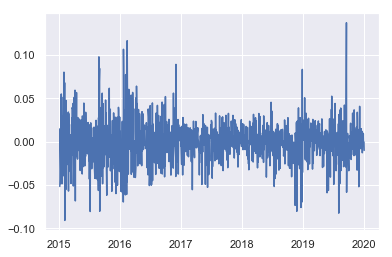

In [13]:
plt.plot(lrets)
plt.show()

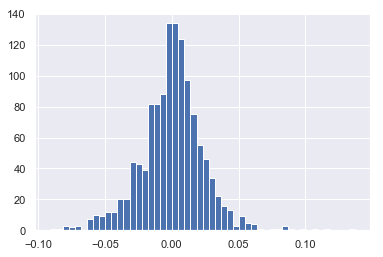

In [14]:
plt.hist(lrets,bins=50)
plt.show()

Check normality

In [15]:
from helper_functions.evaluate_timeseries import evaluate_ts_data

Estimate parameters for GBM

In [22]:
sample_mean_returns = np.mean(rets)
sample_volatility_returns = np.std(rets)
print(sample_mean_returns, sample_volatility_returns)

1.0004013983936575 0.02389940129353652


Strike prices for average option can be seen on [CME website](https://www.cmegroup.com/trading/energy/crude-oil/west-texas-intermediate-wti-crude-oil-calendar-swap-futures_quotes_settlements_options.html?optionProductId=2767&optionExpiration=2767-H0#optionProductId=2767&optionExpiration=2767-H0&tradeDate=03%2F23%2F2020). Strikes are there in cents.

In [35]:
strike = 20 # in USD per barrel
discount_rate = 0.1
time_to_maturity = 1.0/12.0 # value of 1 means one year so 1/12th is one month
current_price = selected_ti.iloc[-1,0] # latest future price
steps = 20 # calculate business days in a month
simulations = 50
drift_strength = sample_mean_returns
volatility = sample_volatility_returns
position_flag = "c" # simulate for call option

In [36]:
from simulations.gbm import asian_gbm_fixed
price, paths, step_range = asian_gbm_fixed(
    current_price, 
    strike,
    position_flag=position_flag,
    time_to_maturity=time_to_maturity,
    steps=steps,
    simulations=simulations,
    drift_strength=drift_strength,
    v=volatility,
    r=discount_rate
    )

Price:  6.324729212667231


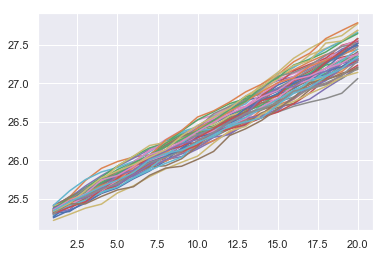

In [37]:
print("Price: ", price)
for path in paths:
    plt.plot(step_range,path)
plt.show()

The model used above is a simplification, since the returns are not normally distributed, as can be seen below. Distribution is almost symmetrical, its kurtosis is however much bigger than that of normal distribution. The data are therefore leptokurtic and have fatter tails.


Jarque Bera test (tests for normality of data)
        Score        p value      skew  kurtosis
0  517.487233  4.256721e-113  0.336508  6.066586

Ljung-Box test ( tests autocorrelation)
     lb_stat  lb_pvalue
30  43.32875   0.054796


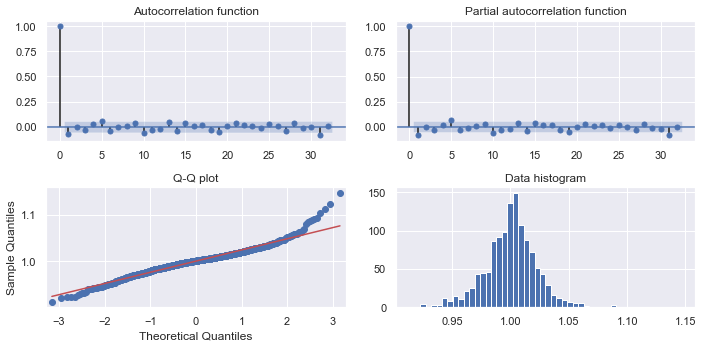

In [24]:
from helper_functions.evaluate_timeseries import evaluate_ts_data
evaluate_ts_data(rets)

Based on the tests above we can see that while there is very little autocorrelation, the returns are not normally distributed and therefore the GBM is not an accurate representation of WTI futures prices. The model would be sufficient in times when the oil and its futures do not have sudden extreme price changes.